In [37]:
import tensorflow as tf
from tensorflow.keras import models, layers
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

In [38]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import PReLU
from tensorflow.keras import utils
from keras.optimizers import Adam

In [39]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [40]:
"""
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg
"""
df = tf.keras.preprocessing.image_dataset_from_directory(
    "coches",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE)

Found 7761 files belonging to 6 classes.


In [41]:
class_names = df.class_names
class_names

['bmw', 'ford', 'mercedes', 'nissan', 'toyota', 'volkswagen']

In [42]:
df.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [43]:
#image_batch[i].numpy().astype("uint8")

In [44]:
for image_batch, label_batch in df.take(1):
    print(image_batch.shape)
    print(label_batch)

(32, 256, 256, 3)
tf.Tensor([5 5 4 4 0 4 4 3 4 2 5 5 2 5 3 0 0 3 0 3 0 5 1 2 0 4 1 4 0 1 3 4], shape=(32,), dtype=int32)


- Aquí tienes algunos ejemplos comunes de tipos de datos "uint" en Python y su rango de valores correspondiente:

* "uint8": Entero sin signo de 8 bits, rango de 0 a 255.
* "uint16": Entero sin signo de 16 bits, rango de 0 a 65535.
* "uint32": Entero sin signo de 32 bits, rango de 0 a 4294967295.
* "uint64": Entero sin signo de 64 bits, rango de 0 a 18446744073709551615.

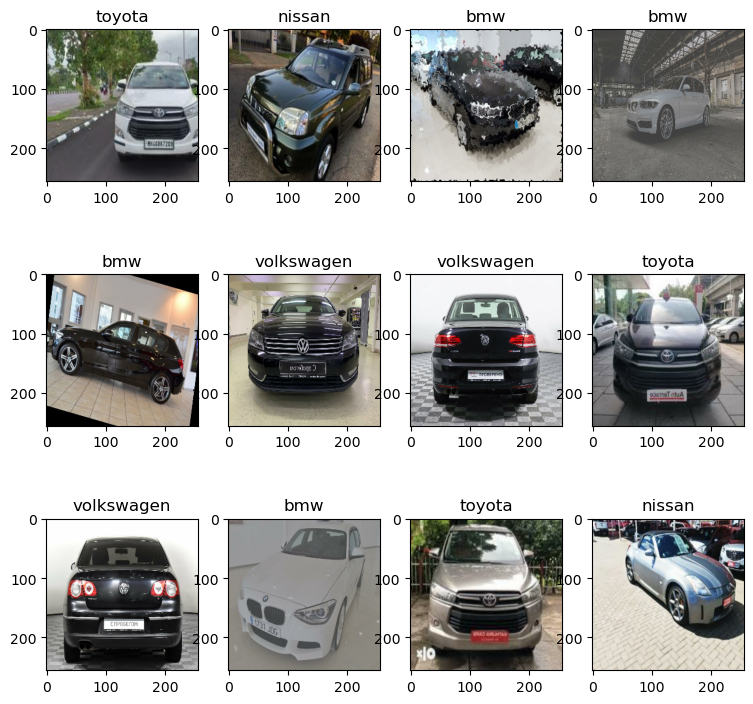

In [45]:
plt.figure(figsize=(9,9))
for image_batch, label_batch in df.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

 * 80& == training
 * 20% == 10% validation, 10% test

In [46]:
def train_test_split_tf(df,train_split = 0.8,val_split = 0.1,test_split=0.1,shuffle = True,shuffe_size = 10000):
    
    if shuffle:
        df = df.shuffle(shuffe_size, seed = 12)
    df_size = len(df)
    train_size = int(train_split*df_size) 
    val_size = int(val_split * df_size)
    
    train_df = df.take(train_size)
    
    val_df = df.skip(train_size).take(val_size)
    test_df = df.skip(train_size).skip(val_size)
    
    return train_df,val_df,test_df 

In [47]:
tf.data.AUTOTUNE

-1

In [48]:
194+24+25

243

In [49]:
train_df,val_df, test_df = train_test_split_tf(df)


In [50]:
print(f"""
    {len(train_df)} Entrenamiento
    {len(val_df)} Validation
    {len(test_df)} Testeo  
      """)


    194 Entrenamiento
    24 Validation
    25 Testeo  
      


# lee imagen y mantiene image en mem , prefeth will load el siguiente lote de datos y lo almacena en memoria

In [51]:
train_df = train_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_df = val_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_df = test_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [52]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [53]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

# Creating a Convolutional Neural NetWork

In [54]:
n_clases = 6
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(32,(3,3),activation = "relu",input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Dropout(0.5),
    
    layers.Conv2D(64,(3,3),activation = "relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Dropout(0.5),
    
    layers.Conv2D(64,(3,3),activation = "relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,(3,3),activation = "relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,(3,3),activation = "relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,(3,3),activation = "relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_clases,activation= "softmax"),
])
model.build(input_shape =input_shape)
    

In [55]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (32, 127, 127, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                      

In [56]:
callbacks = [EarlyStopping(monitor = "val_accuracy",
                          patience = 2,
                          restore_best_weights=True)]

In [57]:
Adam_optimizer = Adam(learning_rate=0.1, beta_1=0.0, beta_2=0.0, epsilon=None, decay=0.0, amsgrad=False)

In [58]:

model.compile(optimizer = "adam",loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics = ["accuracy"])

In [59]:
##################################################

In [60]:
model = models.load_model("modelo2capasDROPOUT.h5")

In [25]:
##################################################

In [127]:
story = model.fit(train_df, epochs=100,batch_size=BATCH_SIZE,verbose = 1, validation_data=val_df)

Epoch 1/100
194/194 [==============================] - 265s 1s/step - loss: 1.7433 - accuracy: 0.2408 - val_loss: 1.7121 - val_accuracy: 0.3190
Epoch 2/100
194/194 [==============================] - 230s 1s/step - loss: 1.6003 - accuracy: 0.3415 - val_loss: 1.6275 - val_accuracy: 0.3633
Epoch 3/100
194/194 [==============================] - 228s 1s/step - loss: 1.3879 - accuracy: 0.4224 - val_loss: 1.6304 - val_accuracy: 0.3698
Epoch 4/100
194/194 [==============================] - 228s 1s/step - loss: 1.2710 - accuracy: 0.4550 - val_loss: 1.5089 - val_accuracy: 0.4115
Epoch 5/100
194/194 [==============================] - 250s 1s/step - loss: 1.2070 - accuracy: 0.4846 - val_loss: 1.7845 - val_accuracy: 0.3802
Epoch 6/100
194/194 [==============================] - 251s 1s/step - loss: 1.1374 - accuracy: 0.5014 - val_loss: 1.3804 - val_accuracy: 0.4323
Epoch 7/100
194/194 [==============================] - 251s 1s/step - loss: 1.1061 - accuracy: 0.5148 - val_loss: 1.6176 - val_accuracy:

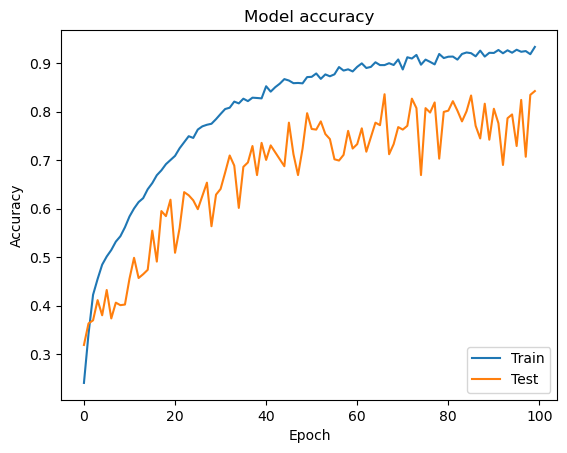

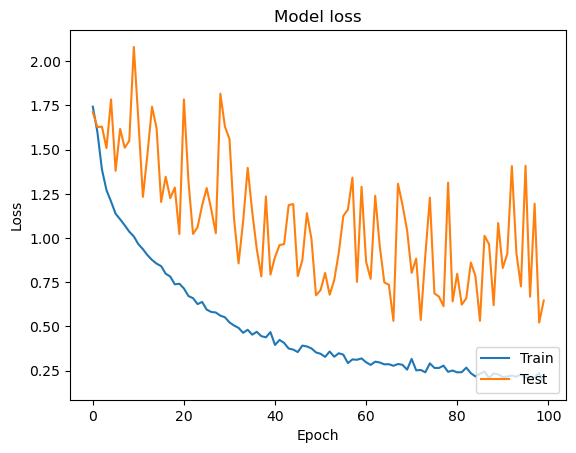

In [129]:
plt.plot(story.history['accuracy'])
plt.plot(story.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(story.history['loss'])
plt.plot(story.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [61]:
clase_estimado = []
clase_actual = []
import numpy as np
for images_batch, labels_batch in test_df.take(26):
    
    batch_predictions = model.predict(images_batch)
    for i,image in enumerate(batch_predictions):
        clase_estimado.append(class_names[np.argmax(batch_predictions[i])])
    for i,image in enumerate(labels_batch):
        clase_actual.append(class_names[labels_batch[i].numpy()])

1/1 [==============================] - 0s 236ms/step


In [62]:
from sklearn.metrics import classification_report
y_true = clase_actual
y_pred = np.array(clase_estimado)

In [63]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

         bmw       0.82      0.56      0.67       108
        ford       0.85      0.84      0.85       103
    mercedes       0.92      0.79      0.85       108
      nissan       0.87      0.84      0.86        99
      toyota       0.94      0.94      0.94       204
  volkswagen       0.76      1.00      0.87       178

    accuracy                           0.86       800
   macro avg       0.86      0.83      0.84       800
weighted avg       0.86      0.86      0.85       800



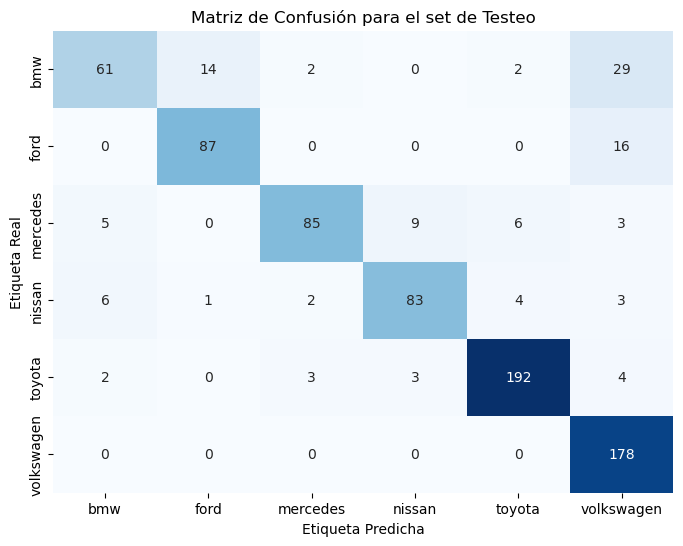

In [64]:




cm = confusion_matrix(y_true, y_pred)

# Crear un mapa de calor de la matriz de confusión utilizando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,xticklabels=class_names,yticklabels=class_names)

# Añadir etiquetas y títulos
plt.title('Matriz de Confusión para el set de Testeo')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.savefig("CNNMatriz.png")
# Mostrar la matriz de confusión
plt.show()

Imagen a predecir
equiqueta actual:  toyota
1/1 [==============================] - 0s 219ms/step
 EL modelo predice :toyota


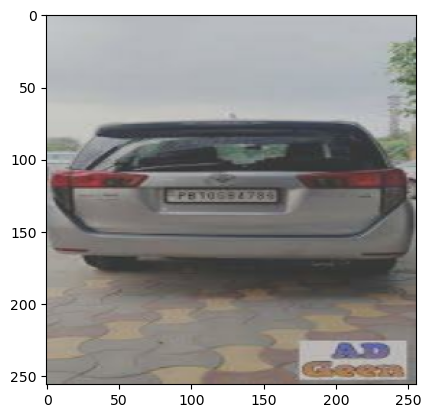

In [65]:
import numpy as np
for images_batch, labels_batch in test_df.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    print("Imagen a predecir")
    plt.imshow(first_image)
    print("equiqueta actual: ",class_names[first_label])
    batch_predictions = model.predict(images_batch)
    print(f" EL modelo predice :{class_names[np.argmax(batch_predictions[0])]}")

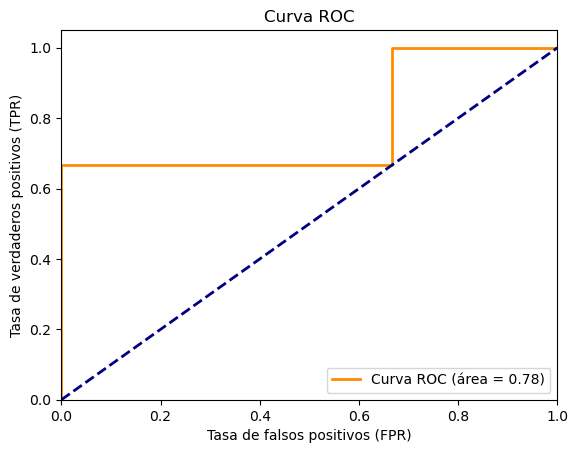

In [66]:
from sklearn.metrics import roc_curve, auc

# Valores de verdad
y_true = np.array([0, 1, 1, 0, 1, 0])  # Ejemplo ficticio, reemplazar con los valores verdaderos reales

# Puntuaciones de las clases predichas (basadas en la probabilidad de pertenencia a la clase positiva)
y_scores = np.array([0.7, 0.4, 0.9, 0.2, 0.8, 0.6])  # Ejemplo ficticio, reemplazar con las puntuaciones reales

# Calcula la tasa de falsos positivos (FPR), la tasa de verdaderos positivos (TPR) y los umbrales utilizando roc_curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Calcula el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Grafica la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()





In [67]:
from keras.utils.vis_utils import plot_model

# ... código para crear tu modelo ...

# Visualizar el diagrama de la red neuronal
plot_model(model, to_file='CNN.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


model

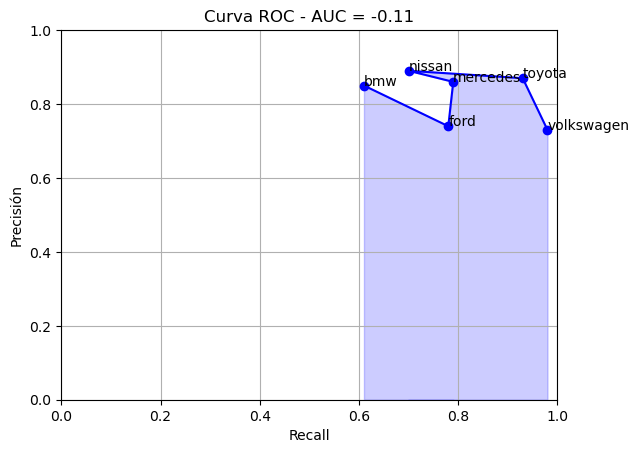

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Datos de precisión, recuperación y etiquetas de clase
precision = [0.85, 0.74, 0.86, 0.89, 0.87, 0.73]
recall = [0.61, 0.78, 0.79, 0.70, 0.93, 0.98]
class_labels = ['bmw', 'ford', 'mercedes', 'nissan', 'toyota', 'volkswagen']

# Calcular el área debajo de la curva ROC
auc_roc = np.trapz(recall, precision)

# Plotear la curva ROC
plt.plot(recall, precision, marker='o', linestyle='-', color='b')
plt.fill_between(recall, precision, alpha=0.2, color='b')

# Etiquetas de clase en los puntos correspondientes
for i, label in enumerate(class_labels):
    plt.annotate(label, (recall[i], precision[i]))

# Configurar límites y etiquetas de los ejes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curva ROC - AUC = {:.2f}'.format(auc_roc))

# Mostrar el gráfico
plt.grid(True)
plt.show()

In [ ]:
# Ruta del archivo para guardar el modelo
model_path = "./modelo.h5"

# Guardar el modelo
model.save(model_path)

print("Modelo guardado en:", model_path)

In [147]:
# Ruta del archivo para guardar el modelo
model_path = "./modelo2capasDROPOUT.h5"

# Guardar el modelo
model.save(model_path)

print("Modelo guardado en:", model_path)

Modelo guardado en: ./modelo2capasDROPOUT.h5


In [ ]:
import tensorflow as tf

# Obtener la lista de dispositivos GPU disponibles
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Imprimir información sobre cada GPU
    for gpu in gpus:
        print('Dispositivo GPU:', gpu)
else:
    print('No se ha detectado ninguna GPU')

# Tu código de TensorFlow que utiliza la GPU aquí

In [ ]:
"""import matplotlib.image as mpimg

# Ruta de la imagen
imagen_path = 'np_prefecth.jpg'

# Cargar la imagen
imagen = mpimg.imread(imagen_path)

# Mostrar la imagen
plt.imshow(imagen)
plt.axis('off')  # Opcional: desactiva los ejes
plt.show()"""